# Overview of Dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
# read the file and create a pandas dataframe
data = pd.read_csv('diabetic_data.csv')

In [4]:
# check the dimensions of the data
data.shape

(101766, 50)

In [5]:
# take a first look at the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
# first 5 rows of data
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# The Response Variable: 'readmitted'

Text(0, 0.5, 'Count')

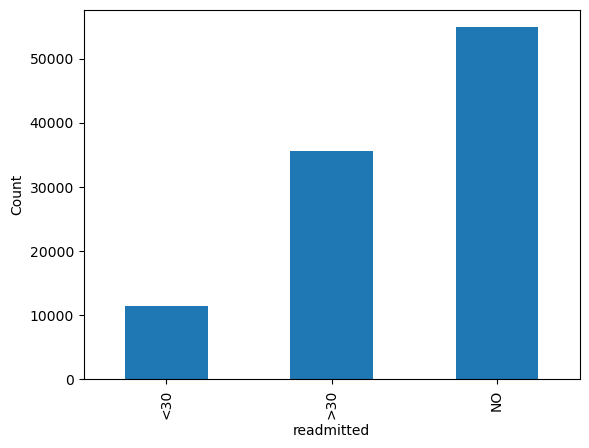

In [7]:
# the response variable 'readmitted' in the original dataset contains three categories.
# 11% of patients were readmitted within 30 days (<30)
# 35% of patients were readmitted after 30 days (>30)
# 54% of patients were never readmitted (NO)
data.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

In [8]:
# recode the response variable so that it becomes a binary classification task.
# '0' means no readmission
# '1' means readmission no matter how many days after being discharged
data['readmitted'] = pd.Series([0 if val == 'NO' else 1 for val in data['readmitted']])
data_origin = data

Text(0, 0.5, 'Count')

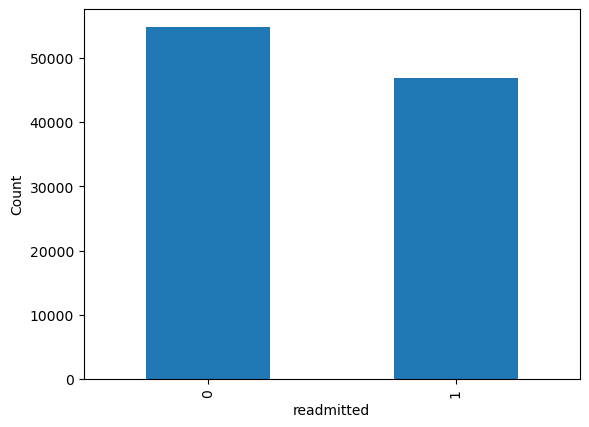

In [9]:
# plot 'readmitted' again to see the change
data.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

# Feature Engineering and EDA

Explore data analysis on each feature and decide how to deal with them.

In [10]:
# remove irrelevant features
data.drop(['encounter_id', 'patient_nbr', 'payer_code'], axis=1, inplace=True)

In [11]:
# check NA in 'weight'
data[data['weight'] == '?'].shape[0] * 1.0 / data.shape[0]

0.9685847925633315

In [12]:
# check NA in 'medical_specialty'
data[data['medical_specialty'] == '?'].shape[0] * 1.0 / data.shape[0]

0.49082208203132677

In [13]:
# remove 'weight' and 'medical_specialty' because it's hard to do imputation on them
data.drop(['weight', 'medical_specialty'], axis=1, inplace=True)

In [14]:
# remove rows that have NA in 'race', 'diag_1', 'diag_2', or 'diag_3'
# remove rows that have invalid values in 'gender'
data = data[data['race'] != '?']
data = data[data['diag_1'] != '?']
data = data[data['diag_2'] != '?']
data = data[data['diag_3'] != '?']
data = data[data['gender'] != 'Unknown/Invalid']

Text(0, 0.5, 'Count')

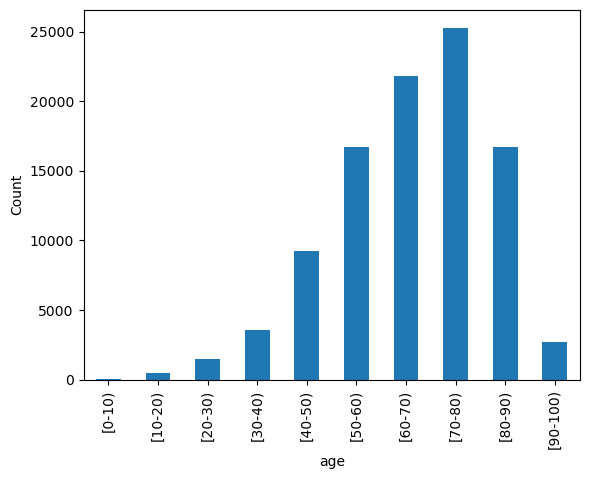

In [15]:
# check 'age' feature
data.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

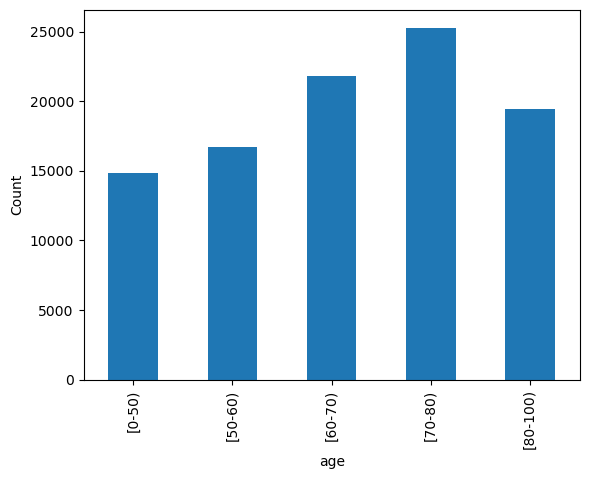

In [16]:
# Recategorize 'age' so that the population is more evenly distributed
data['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                         for val in data['age']], index=data.index)
data['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                         for val in data['age']], index=data.index)

data.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

In [17]:
# original 'discharge_disposition_id' contains 28 levels
# reduce 'discharge_disposition_id' levels into 2 categories
# discharge_disposition_id = 1 corresponds to 'Discharge Home'
data['discharge_disposition_id'] = pd.Series(['Home' if val == 1 else 'Other discharge' 
                                              for val in data['discharge_disposition_id']], index=data.index)

In [18]:
# original 'admission_source_id' contains 25 levels
# reduce 'admission_source_id' into 3 categories
data['admission_source_id'] = pd.Series(['Emergency Room' if val == 7 else 'Referral' if val == 1 else 'Other source' 
                                              for val in data['admission_source_id']], index=data.index)

In [19]:
# original 'admission_type_id' contains 8 levels
# reduce 'admission_type_id' into 2 categories
data['admission_type_id'] = pd.Series(['Emergency' if val == 1 else 'Other type' 
                                              for val in data['admission_type_id']], index=data.index)

Text(0, 0.5, 'Count')

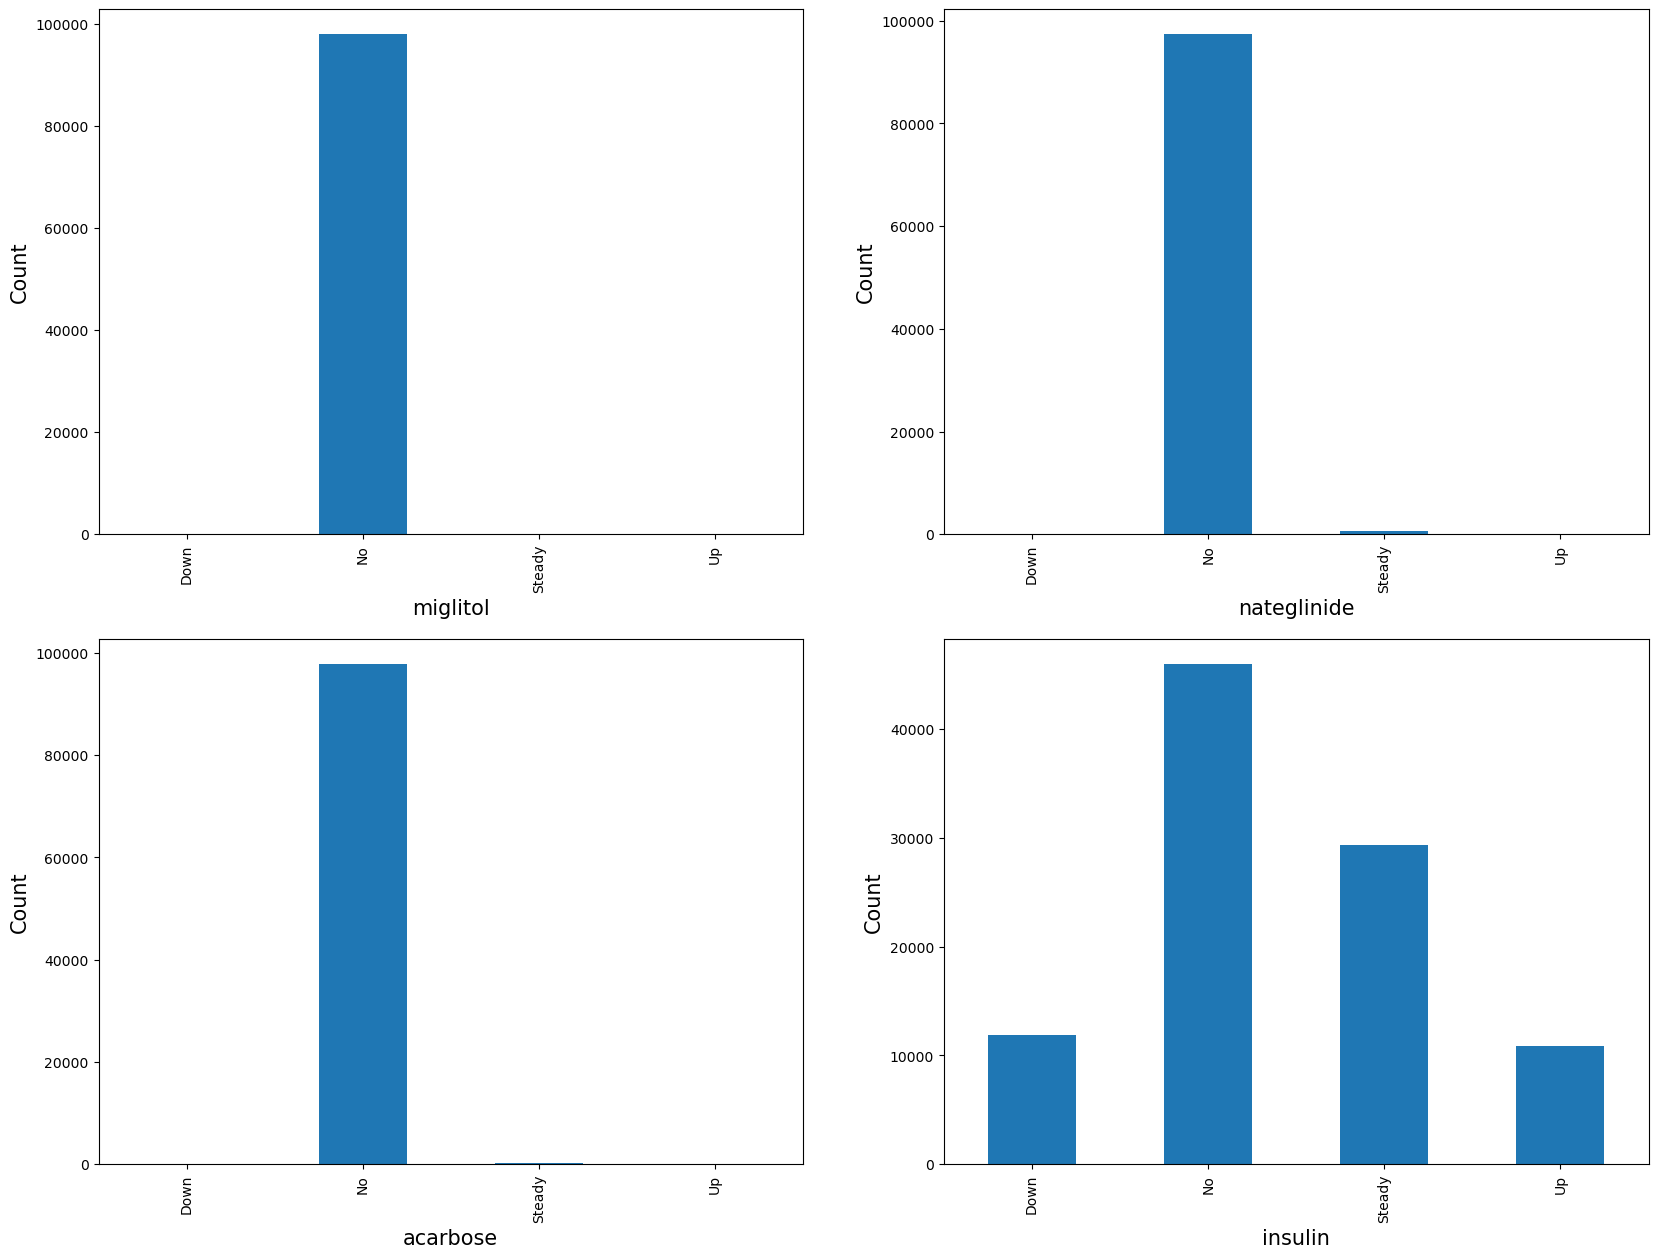

In [20]:
# compare diabetes medications 'miglitol', 'nateglinide' and 'acarbose' with 'insulin', as an example
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(221)
ax1 = data.groupby('miglitol').size().plot(kind='bar')
plt.xlabel('miglitol', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax2 = fig.add_subplot(222)
ax2 = data.groupby('nateglinide').size().plot(kind='bar')
plt.xlabel('nateglinide', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax3 = fig.add_subplot(223)
ax3 = data.groupby('acarbose').size().plot(kind='bar')
plt.xlabel('acarbose', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax4 = fig.add_subplot(224)
ax4 = data.groupby('insulin').size().plot(kind='bar')
plt.xlabel('insulin', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [21]:
# keep only 'insulin' and remove the other 22 diabetes medications
data.drop(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
           'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
           'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
           'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
           'metformin-rosiglitazone', 'metformin-pioglitazone'], axis=1, inplace=True)

In [22]:
# denote 'diag_1' as '1' if it relates to diabetes and '0' if it's not
# remove 'diag_2' and 'diag_3'
data['diag_1'] = pd.Series([1 if val.startswith('250') else 0 for val in data['diag_1']], index=data.index)
data.drop(['diag_2', 'diag_3'], axis=1, inplace=True)

In [23]:
data.shape

(98052, 21)

In [24]:
# we end up with 98052 rows, 20 features, and one response variable 'readmitted' 
list(data.columns.values)

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'insulin',
 'change',
 'diabetesMed',
 'readmitted']

# Data Preprocessing

In [25]:
df_age = pd.get_dummies(data['age'])
df_race = pd.get_dummies(data['race'])
df_gender = pd.get_dummies(data['gender'])
df_max_glu_serum = pd.get_dummies(data['max_glu_serum'])
df_A1Cresult = pd.get_dummies(data['A1Cresult'])
df_insulin = pd.get_dummies(data['insulin'])
df_change = pd.get_dummies(data['change'])
df_diabetesMed = pd.get_dummies(data['diabetesMed'])
df_discharge_disposition_id = pd.get_dummies(data['discharge_disposition_id'])
df_admission_source_id = pd.get_dummies(data['admission_source_id'])
df_admission_type_id = pd.get_dummies(data['admission_type_id'])

data = pd.concat([data, df_age, df_race, df_gender, df_max_glu_serum, df_A1Cresult, 
                  df_insulin, df_change, df_diabetesMed, df_discharge_disposition_id, 
                  df_admission_source_id, df_admission_type_id], axis=1)

data.drop(['age', 'race', 'gender', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 
           'diabetesMed', 'discharge_disposition_id', 'admission_source_id', 
           'admission_type_id'], axis=1, inplace=True)


In [26]:
data['number_outpatient'] = data['number_outpatient'].apply(lambda x: np.sqrt(x + 0.5))
data['number_emergency'] = data['number_emergency'].apply(lambda x: np.sqrt(x + 0.5))
data['number_inpatient'] = data['number_inpatient'].apply(lambda x: np.sqrt(x + 0.5))

In [27]:
# feature scaling, features are standardized to have zero mean and unit variance
feature_scale_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                      'number_diagnoses', 'number_inpatient', 'number_emergency', 'number_outpatient']

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data[feature_scale_cols])
data_scaler = scaler.transform(data[feature_scale_cols])

data_scaler_df = pd.DataFrame(data=data_scaler, columns=feature_scale_cols, index=data.index)
data.drop(feature_scale_cols, axis=1, inplace=True)
data = pd.concat([data, data_scaler_df], axis=1)

# Feature Importance

In [28]:
# create X (features) and y (response)
X = data.drop(['readmitted'], axis=1)
y = data['readmitted']

In [29]:
from sklearn.model_selection import train_test_split

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.25)

Top 6 features are: 
num_lab_procedures
num_medications
time_in_hospital
num_procedures
number_diagnoses
number_inpatient


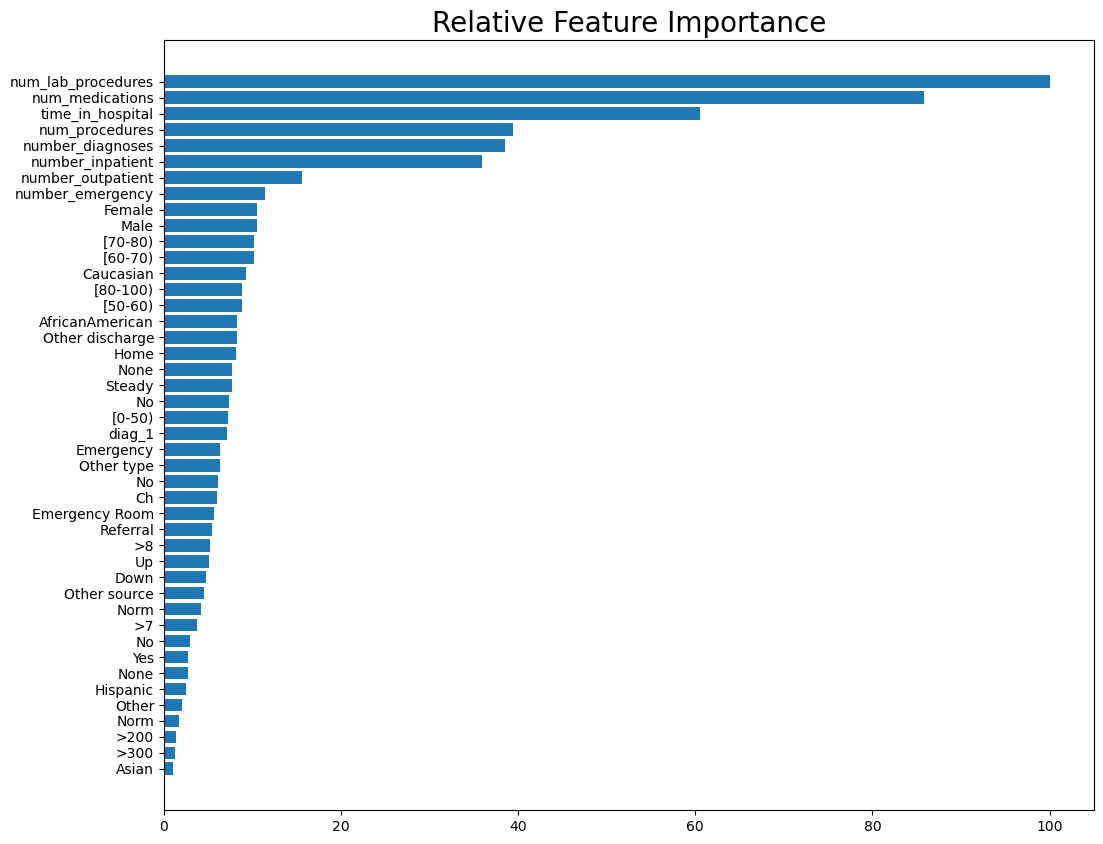

In [30]:
# fit Random Forest model to the cross-validation data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_cv, y_cv)
importances = forest.feature_importances_

# make importance relative to the max importance
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_cv.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print ('Top 6 features are: ')
for feature in feature_names_sort[::-1][:6]:
    print (feature)

# plot the result
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
plt.title('Relative Feature Importance', fontsize=20)
plt.show()

In [31]:
# make a smaller feature set which only contains the top 6 features
X_cv_top6 = X_cv[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses',
           'number_inpatient']]

# Model Selection

Compare the performance of five machine learning algorithms: Random Forest, Naive Bayes,Logistic Regression and knearestneighbor.

Select the best model using 10-fold cross validation. The metric that will be using is the accuracy of prediction.

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier()
RF_score = cross_val_score(clf1, X_cv, y_cv, cv=10, scoring='accuracy').mean()
RF_score

0.6085885791020825

In [34]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
NB_score = cross_val_score(clf2, X_cv, y_cv, cv=10, scoring='accuracy').mean()
NB_score

0.5989882709167862

In [35]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf3 = LogisticRegression()
LR_score = cross_val_score(clf3, X_cv, y_cv, cv=10, scoring='accuracy').mean()
LR_score

0.6179578907127243

In [36]:
# KNeighbor
from sklearn.neighbors import KNeighborsClassifier
knc4 = KNeighborsClassifier()
kn_score = cross_val_score(knc4, X_cv, y_cv, cv=10, scoring='accuracy').mean()
kn_score

0.5768368184302826

Text(0, 0.5, 'Cross-Validated Accuracy')

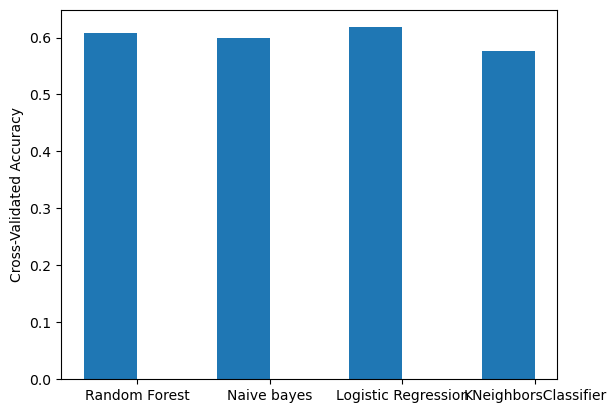

In [38]:
# plot and compare the scores
# LR outperforms the other four a little bit
x_axis = np.arange(4)
y_axis = [RF_score, NB_score, LR_score,kn_score]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.4/2., ('Random Forest', 'Naive bayes', 'Logistic Regression','KNeighborsClassifier'))
plt.ylabel('Cross-Validated Accuracy')

In [39]:
# Logistic Regression on Top 6 features
# still be able to achieve good result with reduced running time
LR_score_top = cross_val_score(clf3, X_cv_top6, y_cv, cv=10, scoring='accuracy').mean()
LR_score_top

0.6119610210918149